# Feature Extraction using CNN

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import cv2
import os

In [125]:
np.random.seed(42)

In [50]:
#Image path
img_path = '../data/box_img/'

#label 
label = pd.read_csv('../data/Standard.csv')['Thickness']

In [126]:
label

0      48.266667
1      47.966667
2      48.166667
3      48.600000
4      59.533333
         ...    
122    84.633333
123    98.366667
124    97.033333
125    96.266667
126    97.766667
Name: Thickness, Length: 127, dtype: float64

In [51]:
for i in range(127):
    Top = np.array(cv2.imread(img_path + 'Top/' + 'Top_' + str(i) + '.jpg'))
    Bot = np.array(cv2.imread(img_path + 'Bot/' + 'Bot_' + str(i) + '.jpg'))
    cat = np.concatenate((Top, Bot), axis = 1)
    cv2.imwrite(img_path + 'Cat/' + 'cat_' + str(i) + '.jpg', cat)


In [157]:
class CustomDataset(Dataset):
    def __init__(self, img_path, label, transform = None):
        self.img_path = img_path
        self.label = label
        self.transform = transform
        
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + 'Cat/' + 'cat_' + str(idx) + '.jpg')
        label = self.label[idx]
        
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label)
            
        return img, label
            
#Transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

#Dataset
dataset = CustomDataset(img_path, label, transform = transform)

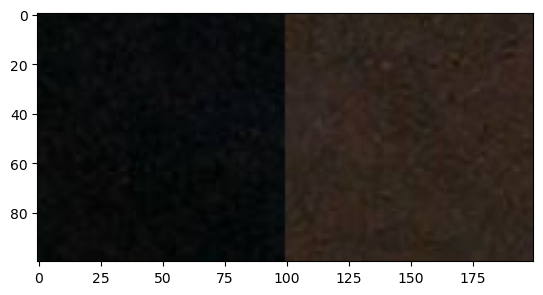

In [158]:
#show image
plt.imshow(dataset[0][0].permute(1, 2, 0))

In [159]:
#split train, test
test_idx = pd.read_csv('../data/test_index.csv')
test_idx = test_idx['test_index'].values
train_idx = list(set(range(127)) - set(test_idx))
print(len(train_idx), len(test_idx))
valid_idx = np.random.choice(train_idx, 20, replace = False)
train_idx = list(set(train_idx) - set(valid_idx))
print(len(train_idx), len(valid_idx), len(test_idx))

88 39
68 20 39


In [160]:
train_dataset = torch.utils.data.Subset(dataset, train_idx)
valid_dataset = torch.utils.data.Subset(dataset, valid_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

In [161]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [162]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 100, 200])

In [163]:
# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm2d(128)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [164]:
model = CNN()

In [165]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    
    return train_loss

def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0
    
    for i, (data, target) in enumerate(test_loader):
        output = model(data)
        loss = criterion(output, target.float().unsqueeze(1))
        
        running_loss += loss.item()
        
    test_loss = running_loss / len(test_loader)
    
    return test_loss

c:\Users\se99a\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\se99a\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 	Train Loss: 762.180298 	Valid Loss : 231.773041 	Test Loss: 695.645294
Model Saved
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Epoch: 10 	Train Loss: 487.362854 	Valid Loss : 641.305847 	Test Loss: 1279.900513
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Epoch: 20 	Train Loss: 391.502462 	Valid Loss : 290.310608 	Test Loss: 823.746490
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Min Loss: 231.773041
Epoch: 30 	Train Loss: 701.374054 	Valid Loss : 245.609711 	Test Loss: 799.682404
Min Loss: 231.773041
Min Loss:

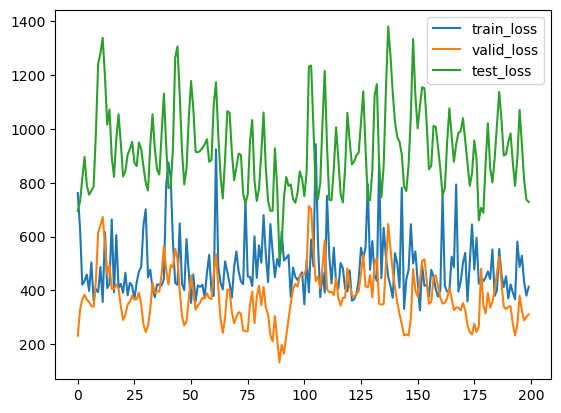

In [171]:
#Training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

train_loss_list = []
valid_loss_list = []
test_loss_list = []

def save_bestmodel(model, min_loss):
    if valid_loss < min_loss:
        torch.save(model.state_dict(), 'model.pt')
        min_loss = valid_loss
        print('Model Saved')
        
    return min_loss
    
min_loss = np.inf

for epoch in range(200):
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = test(model, valid_loader, criterion)
    test_loss = test(model, test_loader, criterion)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    test_loss_list.append(test_loss)
    
    if epoch % 10 == 0:
        print('Epoch: {} \tTrain Loss: {:.6f} \tValid Loss : {:.6f} \tTest Loss: {:.6f}'.format(epoch, train_loss,valid_loss, test_loss))
        
    min_loss = save_bestmodel(model, min_loss)
    print('Min Loss: {:.6f}'.format(min_loss))
    
#Plot
plt.plot(train_loss_list, label = 'train_loss')
plt.plot(valid_loss_list, label = 'valid_loss')
plt.plot(test_loss_list, label = 'test_loss')
plt.legend()

In [172]:
#Predict
model.eval()
pred = []

for i, (data, target) in enumerate(test_loader):
    output = model(data)
    pred.append(output.detach().numpy())
    

pred = np.concatenate(pred, axis = 0)

In [173]:
pred = pd.DataFrame(pred)
pred = pred[0].values
pred

array([90.16991 , 90.95588 , 88.94797 , 87.218956, 85.04589 , 90.44201 ,
       89.50368 , 88.94696 , 88.118095, 87.71143 , 86.64162 , 90.87505 ,
       86.81404 , 91.663765, 88.30796 , 87.956055, 88.288605, 88.345055,
       90.12562 , 87.62202 , 89.04184 , 90.83159 , 88.59555 , 92.29394 ,
       92.94338 , 92.13807 , 88.56257 , 88.83661 , 88.03779 , 83.81672 ,
       91.42156 , 91.220314, 88.365105, 83.826035, 87.06542 , 88.20893 ,
       89.980736, 93.2144  , 91.64318 ], dtype=float32)

Text(0.5, 1.0, 'RMSE: 24.8471')

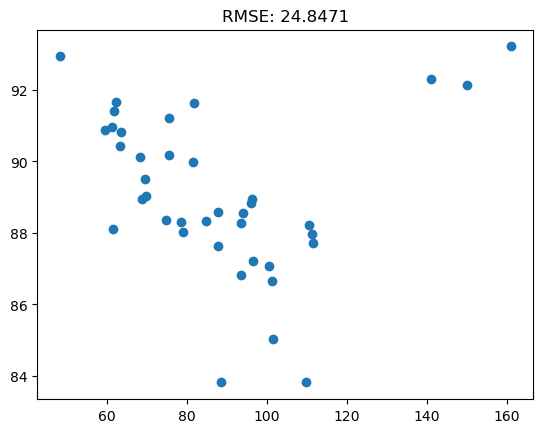

In [174]:
y_test = label[test_idx]
plt.scatter(y_test, pred)
rmse = np.sqrt(np.mean((y_test - pred) ** 2))
plt.title('RMSE: {:.4f}'.format(rmse))